In [1]:
import scipy as sc
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# transfer functions visuals

In [2]:
# Define symbols
s = sp.symbols('s')
D, H, tau = sp.symbols('D H tau')
D1, H1, tau1 = sp.symbols('D1 H1 tau1')
D2, H2, tau2 = sp.symbols('D2 H2 tau2')

# |I| = 1, K = 2
G = (-D - H*s)/(tau*s + 1) - (
    (-D1 - H1*s)/(tau1*s + 1) +
    (-D2 - H2*s)/(tau2*s + 1)
)

print("Symbolic Transfer Function G(s):")
sp.pprint(sp.simplify(G))

Symbolic Transfer Function G(s):
  D + H⋅s   D₁ + H₁⋅s   D₂ + H₂⋅s
- ─────── + ───────── + ─────────
  s⋅τ + 1   s⋅τ₁ + 1    s⋅τ₂ + 1 


Using the fact that:
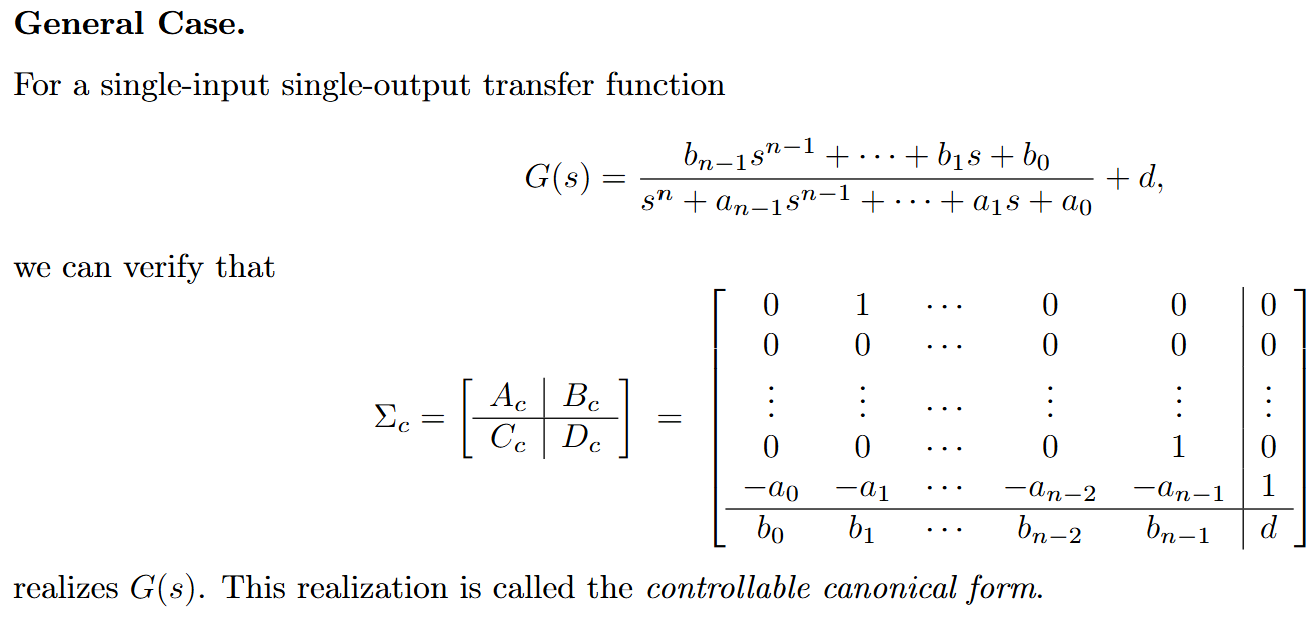

In [3]:
# --- Step 1: simplify into single rational function ---
G_simplified = sp.together(sp.simplify(G))  # forces common denominator
print("\nSimplified G(s):")
sp.pprint(G_simplified)

# --- Step 2: extract numerator and denominator ---
num, den = sp.fraction(G_simplified)

num_poly = sp.Poly(num, s)
den_poly = sp.Poly(den, s)

num_coeffs = num_poly.all_coeffs()
den_coeffs = den_poly.all_coeffs()

print("\nNumerator coefficients:", num_coeffs)
print("Denominator coefficients:", den_coeffs)

# important: devide by den_coeffs[0] always to normalize!!!

# Build controllable canonical form
n = len(den_coeffs) - 1  # system order

# Companion matrix A
A = sp.zeros(n)
for i in range(n-1):
    A[i, i+1] = 1
A[-1, :] = sp.Matrix([[-c/den_coeffs[0] for c in den_coeffs[1:]]])  # FIXED

# Input vector B
B = sp.zeros(n, 1)
B[-1, 0] = 1

# Output vector C
# Pad numerator if needed
m = len(num_coeffs)
if m < n+1:
    num_coeffs = [0]*(n+1-m) + num_coeffs
C = sp.Matrix([[c/den_coeffs[0] for c in num_coeffs[1:]]])

# Feedthrough term Dmat
Dmat = sp.Matrix([[num_coeffs[0]/den_coeffs[0]]])


Simplified G(s):
-(D + H⋅s)⋅(s⋅τ₁ + 1)⋅(s⋅τ₂ + 1) + (D₁ + H₁⋅s)⋅(s⋅τ + 1)⋅(s⋅τ₂ + 1) + (D₂ + H₂ ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                   (s⋅τ + 1)⋅(s⋅τ₁ + 1)⋅(s⋅τ₂ + 1)             ↪

↪ ⋅s)⋅(s⋅τ + 1)⋅(s⋅τ₁ + 1)
↪ ────────────────────────
↪                         

Numerator coefficients: [-H*tau1*tau2 + H1*tau*tau2 + H2*tau*tau1, -D*tau1*tau2 + D1*tau*tau2 + D2*tau*tau1 - H*tau1 - H*tau2 + H1*tau + H1*tau2 + H2*tau + H2*tau1, -D*tau1 - D*tau2 + D1*tau + D1*tau2 + D2*tau + D2*tau1 - H + H1 + H2, -D + D1 + D2]
Denominator coefficients: [tau*tau1*tau2, tau*tau1 + tau*tau2 + tau1*tau2, tau + tau1 + tau2, 1]


In [4]:
from IPython.display import display

print("Controllable Canonical Form:")

print("\nA =")
display(A)   # nice LaTeX rendering

print("\nB =")
display(B)

print("\nC =")
display(C)

print("\nD =")
display(Dmat)


Controllable Canonical Form:

A =


Matrix([
[                                                 0,                                    1,                  0],
[                                                 0,                                    0,                  1],
[(-tau*tau1 - tau*tau2 - tau1*tau2)/(tau*tau1*tau2), (-tau - tau1 - tau2)/(tau*tau1*tau2), -1/(tau*tau1*tau2)]])


B =


Matrix([
[0],
[0],
[1]])


C =


Matrix([[(-D*tau1*tau2 + D1*tau*tau2 + D2*tau*tau1 - H*tau1 - H*tau2 + H1*tau + H1*tau2 + H2*tau + H2*tau1)/(tau*tau1*tau2), (-D*tau1 - D*tau2 + D1*tau + D1*tau2 + D2*tau + D2*tau1 - H + H1 + H2)/(tau*tau1*tau2), (-D + D1 + D2)/(tau*tau1*tau2)]])


D =


Matrix([[(-H*tau1*tau2 + H1*tau*tau2 + H2*tau*tau1)/(tau*tau1*tau2)]])

In [5]:
import control as ct

In [6]:
G = ct.tf([1], [2, 1], input='u1', output='y1')
G2 = ct.tf([1], [5, 1], input='u2', output='y2')
summing = ct.summing_junction(['y1', 'y2'], 'y', name='summing')
Gtot = ct.interconnect([G, G2, summing], inputs=['u1', 'u2'], outputs=['y1', 'y2', 'y'])
T = int(1e2)
t = np.arange(T) * 0.1
u1, u2 = np.ones(T), -np.ones(T)

response = ct.input_output_response(Gtot, t, [u1, u2], [1, -1])
response.outputs.shape

(3, 100)

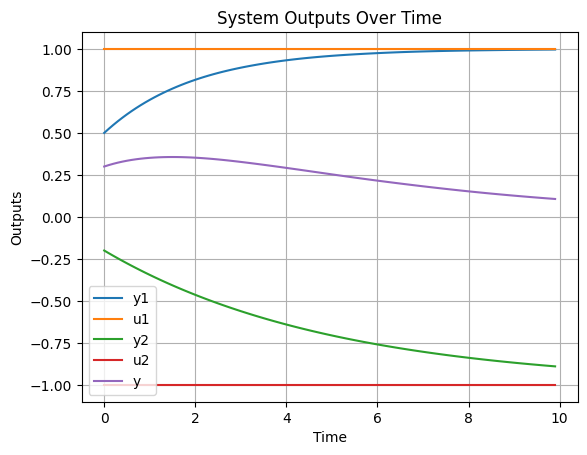

In [7]:
# plot ouput
plt.plot(response.time, response.outputs[0], label='y1')
plt.plot(response.time, response.inputs[0], label='u1')
plt.plot(response.time, response.outputs[1], label='y2')
plt.plot(response.time, response.inputs[1], label='u2')
plt.plot(response.time, response.outputs[2], label='y')
plt.xlabel('Time')
plt.ylabel('Outputs')
plt.legend()
plt.grid()
plt.title('System Outputs Over Time')
plt.show()

# opt bid experiments

In [33]:
def bid_value(bids, rhos, bid,
              return_prob=False):
    gamma = sum(rhos[b] for b in bids if b >= bid)
    if return_prob:
        return gamma
    return bid * (4 * gamma - 3)

In [34]:
def bids_to_values(bids, rhos, return_prob=False) -> np.ndarray:
    values = np.array([bid_value(bids, rhos, b, return_prob=False) for b in bids])
    if not return_prob:
        return values
    else:
        gammas = np.array([bid_value(bids, rhos, b, return_prob=True) for b in bids])
        return gammas, values

In [35]:
# get samples of normal distribution
size = 30
bids = np.random.normal(loc=5, scale=2, size=size)
bids_2 = np.random.normal(loc=7, scale=1.5, size=size)
# sort bids
bids, bids_2 = np.sort(bids), np.sort(bids_2)
rhos = {b: 1/len(bids) for b in bids}  # uniform distribution
rhos_2 = {b: 1/len(bids_2) for b in bids_2}  # uniform distribution
vals = bids_to_values(bids, rhos)
vals_2 = bids_to_values(bids_2, rhos_2)
# get probabilities
gammas_1, _ = bids_to_values(bids, rhos, return_prob=True)
gammas_2, _ = bids_to_values(bids_2, rhos_2, return_prob=True)

In [36]:
# get added bids
added_bids = bids + bids_2
added_rhos = {b: 1/len(added_bids) for b in added_bids}
added_vals = bids_to_values(added_bids, added_rhos)
added_gammas, _ = bids_to_values(added_bids, added_rhos, return_prob=True)

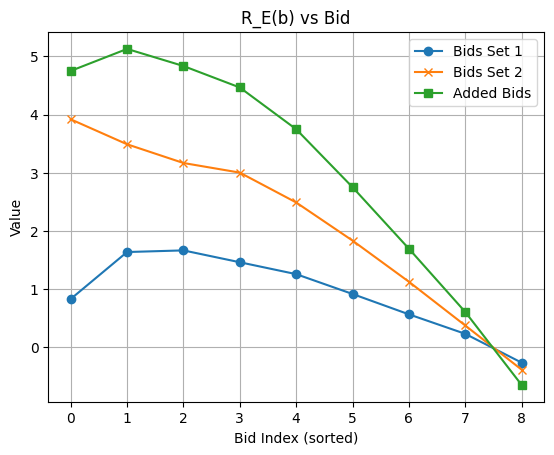

Max value at index 1, bid: 5.919, value: 5.130
Max value set 1 at index 2, bid: 2.273, value: 1.667
Max value set 2 at index 0, bid: 3.921, value: 3.921
Difference of Max: bid12 - (bid1 + bid2)=-0.274493, value12 - (value1 + value2)=-0.457520


In [ ]:
# visualize
# first, cut off at negative values
idx_where_nonneg = np.where(added_vals >= 0)[0][-1] + 2
added_bids = added_bids[:idx_where_nonneg]
added_vals = added_vals[:idx_where_nonneg]
vals = vals[:idx_where_nonneg]
vals_2 = vals_2[:idx_where_nonneg]
x_ks = np.arange(len(added_bids))

plt.plot(x_ks, vals, marker='o', label='Bids Set 1')
plt.plot(x_ks, vals_2, marker='x', label='Bids Set 2')
plt.plot(x_ks, added_vals, marker='s', label='Added Bids')
# plt.plot(x_ks, diff, marker='d', label='Difference')
plt.xlabel('Bid Index (sorted)')
plt.ylabel('Value')
plt.title('R_E(b) vs Bid')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# print idx and bid of max value
max_idx = np.argmax(added_vals)
print(f"Max value at index {max_idx}, bid: {added_bids[max_idx]:.3f}, value: {added_vals[max_idx]:.3f}")
max_idx_1 = np.argmax(vals)
print(f"Max value set 1 at index {max_idx_1}, bid: {bids[max_idx_1]:.3f}, value: {vals[max_idx_1]:.3f}")
max_idx_2 = np.argmax(vals_2)
print(f"Max value set 2 at index {max_idx_2}, bid: {bids_2[max_idx_2]:.3f}, value: {vals_2[max_idx_2]:.3f}")
print(f"Difference of Max: bid12 - (bid1 + bid2)={added_bids[max_idx] - (bids[max_idx_1] + bids_2[max_idx_2]):.6f}, value12 - (value1 + value2)={added_vals[max_idx] - (vals[max_idx_1] + vals_2[max_idx_2]):.6f}")

In [38]:
# ok, now print values for max_idx, i.e. 1 and 2 must choose bids that sum to bid at max_idx
print("For added bid:", added_bids[max_idx])
print(f"Difference of Max: bid12 - (bid1 + bid2)={added_bids[max_idx] - (bids[max_idx] + bids_2[max_idx]):.6f}, value12 - (value1 + value2)={added_vals[max_idx] - (vals[max_idx] + vals_2[max_idx]):.6f}")

For added bid: 5.919489146877522
Difference of Max: bid12 - (bid1 + bid2)=0.000000, value12 - (value1 + value2)=0.000000


In [16]:
(vals[max_idx_1] + vals_2[max_idx_2])

np.float64(6.477191398527561)

In [17]:
# empirical check
import pandas as pd
df = pd.read_csv('pics/v_case_0604/expected_values_DPF.csv', index_col=0, header=[0,1,2])

In [18]:
df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
df.set_index(df.columns[0], inplace=True)
from src.game_theory_helpers import game_is_superadditive
players = [c[0] for c in df.columns if len(c)==1]

In [ ]:
super_additive_couter = 0
for idx, row in df.iterrows():
    # create value function
    v = {frozenset(k): val for k, val in row.items()}
    # add empty set
    v[frozenset()] = 0
    # check super-additivity
    result = game_is_superadditive(v, players, tol=5e-4, print_warnings=True)
    if result:
        print(f"   at index {idx}")
        super_additive_couter += 1
    # else:
    #     print(f"Game not super-additive for index {idx}: {v}")
print(f"Number of super-additive games: {super_additive_couter} out of {len(df)}")

Checking game at index 0...
Checking game at index 1...
Checking game at index 2...
Checking game at index 3...
Checking game at index 4...
Checking game at index 5...
Checking game at index 6...
Game is not superadditive: frozenset({'Wind'}), frozenset({'PV', 'BESS'})
Checking game at index 7...
Checking game at index 8...
Checking game at index 9...
Game is not superadditive: frozenset({'Wind'}), frozenset({'PV', 'BESS'})
Checking game at index 10...
Game is not superadditive: frozenset({'Wind'}), frozenset({'PV', 'BESS'})
Checking game at index 11...
Checking game at index 12...
Game is not superadditive: frozenset({'Wind'}), frozenset({'PV', 'BESS'})
Checking game at index 13...
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind', 'BESS'})
Checking game at index 14...
Checking game at index 15...
Game is not superadditive: frozenset({'PV'}), frozenset({'Wind', 'BESS'})
Checking game at index 16...
Checking game at index 17...
Game is not superadditive: frozenset({'PV'})

## empircal check \#2
check if bids align with theory

In [ ]:
df = pd.read_csv('pics/v_case_0604/bids_DPF_FFR-FCR.csv', header=0)
# df.columns = [tuple(c for c in col if c!='nan') for col in df.columns.values]
# df.set_index(df.columns[0], inplace=True)
# players = [c[0] for c in df.columns if len(c)==1]
K_scenarios = 20
df

,"('PV',)","('Wind',)","('BESS',)","('PV', 'Wind')","('PV', 'BESS')","('Wind', 'BESS')","('PV', 'Wind', 'BESS')"
0,-0.30000,1.26324,-0.3,1.26324,-0.30000,3.64463,3.64463
1,-0.30000,2.37893,-0.3,2.37893,-0.30000,4.54891,4.54891
2,-0.30000,1.53328,-0.3,1.53685,-0.30000,3.86427,3.87327
3,-0.30000,1.61998,-0.3,1.61998,-0.30000,3.88577,3.88577
4,-0.30000,0.99064,-0.3,0.99064,-0.30000,3.09910,3.09910
...,...,...,...,...,...,...,...
175,2.58540,-0.30000,-0.3,2.28685,4.86168,-0.30000,4.75666
176,2.57541,0.43411,-0.3,2.81037,4.84290,1.35805,5.24829
177,3.05363,0.32462,-0.3,3.11901,5.29407,1.01553,5.65555
178,2.69525,-0.30000,-0.3,2.53771,4.93640,-0.30000,5.01742
